In [16]:
# 必要なパッケージを読み込む
using DelimitedFiles, DataFrames, CSV, Plots

# 前提として、以下のファイルが既に存在している
include("calc_IPW.jl")          # リグレット計算の基本関数
include("file_operate.jl")      # ファイル操作用関数
include("module_regret.jl") # 先ほど定義した新しいモジュール

# RankChangeIntervalモジュールを使用
using .RankChangeInterval

# 1. データの読み込み
function load_data(method_name="A/MMRW", repeat_num=1, criteria_num=6)
    # 効用値行列の読み込み
    utility_data = read_utility_value()[1]  # 最初のデータセットを使用
    
    # 区間重要度の読み込み
    method_weights = read_method_weights(method_name, repeat_num, criteria_num)[1]
    
    return utility_data, method_weights
end

# 2. 最適なtの範囲を計算
function calculate_t_range(method_weights)
    t_range = find_optimal_trange(method_weights.L, method_weights.R)
    println("最適t範囲: [", t_range[1], ", ", t_range[2], "]")
    return t_range
end

# 3. アベイルスペースに基づく順位変化点を分析
function analyze_rank_changes(utility_data, method_weights, t_range)
    results = analyze_all_alternatives_with_avail_space(utility_data, method_weights, t_range)
    
    println("検出された傾き変化区間:")
    for (i, interval) in enumerate(results.intervals)
        println("  区間 $i: [", interval[1], ", ", interval[2], "]")
    end
    
    println("\n順位変化点:")
    for (i, t) in enumerate(results.change_points)
        println("  変化点 $i: t = $t")
    end
    
    println("\n各時点での順位:")
    for t in sort(collect(keys(results.rankings)))
        println("  t = $t: ", results.rankings[t])
    end
    
    return results
end

# 4. 結果を可視化する関数
function plot_rank_changes(results)
    # すべての時点をソート
    t_points = sort(collect(keys(results.rankings)))
    n = length(results.rankings[t_points[1]])
    
    # プロット作成
    p = plot(
        xlabel = "t",
        ylabel = "順位",
        title = "代替案の順位変化",
        legend = :outerright,
        size = (800, 500),
        grid = true
    )
    
    # 各代替案の順位変化をプロット
    colors = [:red, :blue, :green, :purple, :orange]
    for alt in 1:n
        # 各代替案の順位の変化を追跡
        ranks = [findfirst(x -> x == alt, results.rankings[t]) for t in t_points]
        plot!(p, t_points, ranks,
            label = "代替案 $alt",
            marker = :circle,
            color = colors[alt],
            linewidth = 2)
    end
    
    # 傾き変化区間の境界を点線で表示
    for (lower, upper) in results.intervals
        vline!(p, [lower], linestyle = :dash, color = :gray, label = nothing, alpha = 0.3)
        vline!(p, [upper], linestyle = :dash, color = :gray, label = nothing, alpha = 0.3)
    end
    
    # 順位変化点を赤い点線で表示
    for cp in results.change_points
        vline!(p, [cp], linestyle = :dash, color = :red, label = nothing)
    end
    
    return p
end

# 5. 結果をCSVに保存する関数
function save_results_to_csv(results, filename="rank_changes.csv")
    # すべての時点をソート
    t_points = sort(collect(keys(results.rankings)))
    n = length(results.rankings[t_points[1]])
    
    # 出力用のDataFrameを作成
    output_data = DataFrame(
        t_point = Float64[],
    )
    
    # 各代替案の列を追加
    for i in 1:n
        output_data[!, "alt_$i"] = Int[]
    end
    
    # 各時点での順位を記録
    for t in t_points
        row = Dict("t_point" => t)
        for i in 1:n
            row["alt_$i"] = findfirst(x -> x == i, results.rankings[t])
        end
        push!(output_data, row)
    end
    
    # CSVに保存
    CSV.write(filename, output_data)
    println("結果を $filename に保存しました")
    
    return output_data
end


save_results_to_csv (generic function with 2 methods)

In [19]:
utility_data, method_weights = load_data("A/MMRW", 1, 6)
println(method_weights)

(L = [0.150363, 0.150363, 0.073647, 0.075181, 0.050121, 0.037591], R = [0.338316, 0.338316, 0.196392, 0.207397, 0.165918, 0.216395], adjacent = 0.925469)


In [9]:
include("not_necessary/display-crisp-matrix.jl")

matrixLaTeXString (generic function with 1 method)

In [18]:
include("not_necessary/display-crisp-matrix.jl")
include("plot_regret_transition.jl")
p = plot_regret_transition(utility_data, method_weights, t_range)
display(p)

MethodError: MethodError: no method matching plot_regret_transition(::Matrix{Float64}, ::NamedTuple{(:L, :R, :adjacent), Tuple{Vector{Float64}, Vector{Float64}, Float64}}, ::Tuple{Float64, Float64})

Closest candidates are:
  plot_regret_transition(::Matrix{Float64}, !Matched::Vector{NamedTuple{(:L, :R, :adjacent), Tuple{Vector{Float64}, Vector{Float64}, Float64}}}, ::Tuple{Float64, Float64})
   @ Main /workspaces/Interval-AHP-alt-rank/src/plot_regret_transition.jl:4


In [5]:
results = analyze_rank_changes(utility_data, method_weights, t_range)

検出された傾き変化区間:
  区間 1: [1.2889787163834352, 1.378893823796674]
  区間 2: [1.2734327544732509, 1.2889787163834352]
  区間 3: [1.2021152419797878, 1.2734327544732509]
  区間 4: [1.1792953474439951, 1.2021152419797878]
  区間 5: [1.1662691632601887, 1.1792953474439951]
  区間 6: [1.1061665466475963, 1.1662691632601887]
  区間 7: [1.101292476850832, 1.1061665466475963]
  区間 8: [1.0475460186966012, 1.101292476850832]
  区間 9: [1.0376016460512512, 1.0475460186966012]
  区間 10: [1.037255091107301, 1.0376016460512512]
  区間 11: [1.0275042333174411, 1.037255091107301]
  区間 12: [1.0202207757758777, 1.0275042333174411]
  区間 13: [0.9805651977800004, 1.0202207757758777]
  区間 14: [0.9739298458853411, 0.9805651977800004]
  区間 15: [0.9653283033293207, 0.9739298458853411]
  区間 16: [0.9650283380571472, 0.9653283033293207]
  区間 17: [0.9565826276942149, 0.9650283380571472]
  区間 18: [0.9157710425870166, 0.9565826276942149]
  区間 19: [0.9124279067900146, 0.9157710425870166]
  区間 20: [0.8752237290657424, 0.9124279067900146]
 

(all_results = Dict{Int64, Any}(5 => (change_points = Float64[], max_regret_alts = Int64[], intervals = [(1.2889787163834352, 1.378893823796674), (1.2734327544732509, 1.2889787163834352), (1.2021152419797878, 1.2734327544732509), (1.1792953474439951, 1.2021152419797878), (1.1662691632601887, 1.1792953474439951), (1.1061665466475963, 1.1662691632601887), (1.101292476850832, 1.1061665466475963), (1.0475460186966012, 1.101292476850832), (1.0376016460512512, 1.0475460186966012), (1.037255091107301, 1.0376016460512512)  …  (0.9650283380571472, 0.9653283033293207), (0.9565826276942149, 0.9650283380571472), (0.9157710425870166, 0.9565826276942149), (0.9124279067900146, 0.9157710425870166), (0.8752237290657424, 0.9124279067900146), (0.8680284296671286, 0.8752237290657424), (0.8560669033406298, 0.8680284296671286), (0.8232343064786071, 0.8560669033406298), (0.8168653283145129, 0.8232343064786071), (0.7844484660502471, 0.8168653283145129)], r_M = 0.018212175419150434, r_m = -0.03857826907734078)

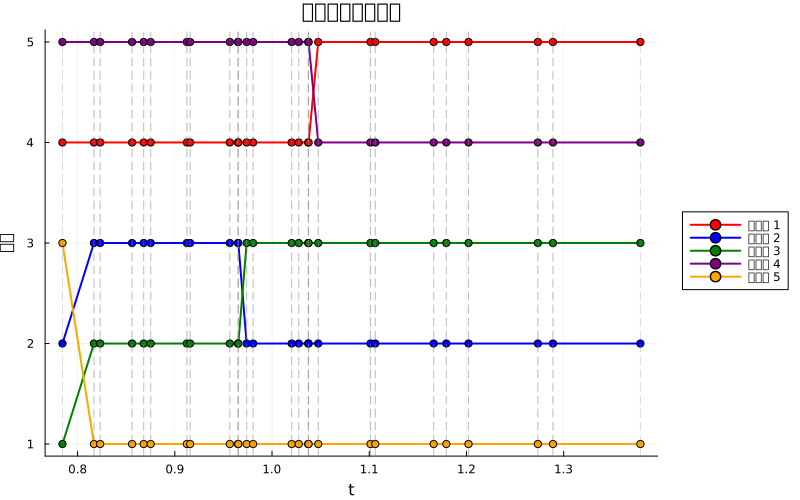

GKS: glyph missing from current font: 20195
GKS: glyph missing from current font: 26367
GKS: glyph missing from current font: 26696
GKS: glyph missing from current font: 12398
GKS: glyph missing from current font: 38918
GKS: glyph missing from current font: 20301
GKS: glyph missing from current font: 22793
GKS: glyph missing from current font: 21270
GKS: glyph missing from current font: 38918
GKS: glyph missing from current font: 20301
GKS: glyph missing from current font: 20195
GKS: glyph missing from current font: 26367
GKS: glyph missing from current font: 26696
GKS: glyph missing from current font: 12398
GKS: glyph missing from current font: 38918
GKS: glyph missing from current font: 20301
GKS: glyph missing from current font: 22793
GKS: glyph missing from current font: 21270
GKS: glyph missing from current font: 38918
GKS: glyph missing from current font: 20301
GKS: glyph missing from current font: 20195
GKS: glyph missing from current font: 26367
GKS: glyph missing from current 

"/workspaces/Interval-AHP-alt-rank/src/rank_changes_plot.png"

In [6]:
rank_plot = plot_rank_changes(results)
display(rank_plot)
savefig(rank_plot, "rank_changes_plot.png")

In [7]:
output_df = save_results_to_csv(results)
display(output_df)

UndefVarError: UndefVarError: `writeshortest` not defined

In [ ]:

# メイン処理
function main()
    # 1. データの読み込み

    
    # 2. tの範囲計算

    
    # 3. 順位変化点分析
    results = analyze_rank_changes(utility_data, method_weights, t_range)
    
    # 4. 結果の可視化
    rank_plot = plot_rank_changes(results)
    display(rank_plot)
    savefig(rank_plot, "rank_changes_plot.png")
    
    # 5. 結果をCSVに保存
    output_df = save_results_to_csv(results)
    display(output_df)
    
    return results
end

# 実行
results = main()